# Import packages

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from glob import glob
import mido
import string
from music21 import midi
from music21 import converter, instrument, note, chord

# dataset
import os
from torch.utils.data import Dataset, DataLoader, random_split

# tensorboard
from torch.utils.tensorboard import SummaryWriter

# Preprocess data

Just trying out the pipeline for one list of files

In [3]:
files = glob("/home/rohit/music-generation/magenta/data/albeniz/*mid")
musicfile = files[0]
print(musicfile)

/home/rohit/music-generation/magenta/data/albeniz/alb_esp3.mid


In [5]:
midi = converter.parse(musicfile)

In [69]:
def file_to_notes(filename):
    # Given 
    notes = []
    diff = []
    curtime = None
    
    midi = converter.parse(filename)
    notes_to_parse = None    
    parts = instrument.partitionByInstrument(midi)    
    if parts: # file has instrument parts
        partlen = [len(x.recurse()) for x in parts.parts]
        idx = np.argmax(partlen)
        notes_to_parse = parts.parts[idx].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes  

    for element in notes_to_parse:
        
        if curtime is None:
            if isinstance(element, note.Note) or isinstance(element, chord.Chord):
                curtime = float(element.offset)
        
        # print(element)
        if isinstance(element, note.Note):
            diff.append(float(element.offset) - curtime)
            notes.append(str(element.pitch))
            curtime = float(element.offset)
        elif isinstance(element, chord.Chord):
            diff.append(float(element.offset) - curtime)
            notes.append('.'.join(str(n) for n in element.normalOrder))
            curtime = float(element.offset)
    return notes, diff

In [70]:
notes, diff = file_to_notes(musicfile)

In [73]:
notes

['B4',
 'B3',
 'E-5',
 'E-4',
 'F#5',
 'F#4',
 'E5',
 'E4',
 'F#5',
 'F#4',
 'E5',
 'E4',
 'C5',
 'C4',
 'A5',
 'A4',
 'B4',
 'B3',
 'E-5',
 'E-4',
 'F#5',
 'F#4',
 'E5',
 'E4',
 'F#5',
 'F#4',
 'E5',
 'E4',
 'C5',
 'C4',
 'A5',
 'A4',
 'B3',
 'B4',
 'F#4',
 'E-5',
 'F#5',
 'E5',
 'F#5',
 'E5',
 'C5',
 'A5',
 'B4',
 'E-5',
 'F#5',
 'E5',
 'F#5',
 'E5',
 'C5',
 'G4',
 'A5',
 'F#4',
 'B4',
 'A4',
 'E-5',
 'F#5',
 'G4',
 'A4',
 'G4',
 'E5',
 'F#4',
 'F#5',
 'E5',
 'C5',
 'A5',
 'B4',
 'E-5',
 'F#5',
 'E5',
 'F#5',
 'E5',
 'C5',
 'A5',
 'B4',
 'E-5',
 'F#5',
 'C5',
 'E4',
 'G5',
 'C6',
 'F#4',
 'E4',
 'F#5',
 'D4',
 'B5',
 'F#6',
 'E6',
 '0.6',
 'A6',
 'E7',
 '11.3',
 'F#7',
 'B3',
 'E-5',
 'A4',
 'F#5',
 'F#4',
 'E5',
 'G4',
 'F#5',
 'E5',
 'C5',
 'E4',
 'A5',
 'G4',
 'B4',
 'F#4',
 'E-5',
 'A4',
 'F#5',
 'F#4',
 'E5',
 'G4',
 'F#5',
 'E5',
 'C5',
 'E4',
 'A5',
 'G4',
 '6.11',
 'E-4',
 '5.8',
 'D4',
 '4.9',
 'C#4',
 '3.6',
 'C4',
 '2.7',
 'B3',
 '0.2',
 'F#3',
 '11.2',
 'G3',
 'G4',
 'B3'

# Visualize & playback 10 sec clip

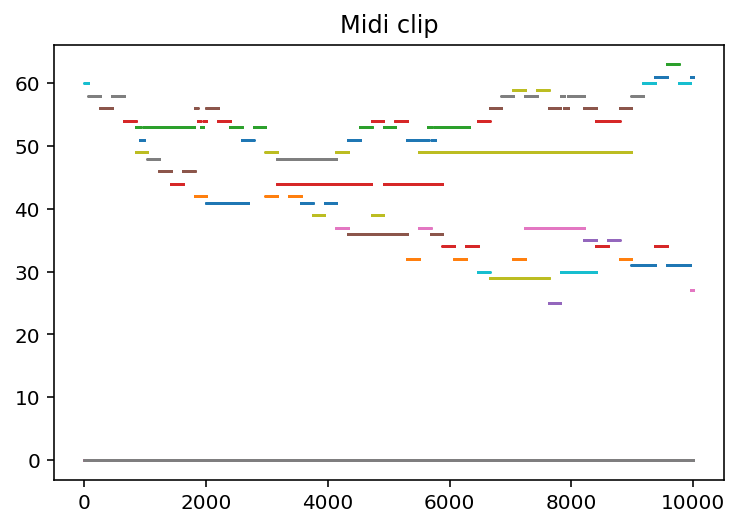

Artist idx 0


In [8]:
data = np.load('./preprocessed_dataset/data/1.npz')
part = data['clip']
plt.plot(range(part.shape[0]), np.multiply(np.where(part>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("Midi clip")
plt.show()
print('Artist idx', data['artist_idx'])

def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

mid = arry2mid(part)
mid.save('sample.mid')


from music21 import midi

mf = midi.MidiFile()
mf.open('sample.mid') # path='abc.midi'
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
s.show('midi')

# Create pytorch dataset

In [41]:
# Parameters
nAgents = 6
obsDim = 2
inpDim = nAgents*obsDim
hiddenDim = 2*nAgents
outDim = nAgents
initSteps = 10
batch_size = 20
val_frac = 0.2

# dataset for classification
class classifyDataset(Dataset):
    def __init__(self, root_dir, num_artists=10, obs_dim=88, init_steps=1000):
        self.root_dir = root_dir
        self.num_artists = num_artists
        self.obs_dim = obs_dim
        self.init_steps = init_steps
        self.num_files = len(os.listdir(os.path.join(root_dir, 'data')))
        self.files = [os.path.join(root_dir, 'data', '{}.npz'.format(i)) for i in range(self.num_files)]
    def __len__():
        return self.num_files
    
    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        return torch.FloatTensor(data['clip']),\
               torch.tensor(data['artist_idx'])

myDataset = classifyDataset('./preprocessed_dataset')


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [ ]:
musicData = midiDataset('here')

class TrajDataset(Dataset):
    # swarm trajectory dataset                                      
    def __init__(self, root_dir, num_artists = 10, obs_dim=88, init_steps=1000:
        self.root_dir = root_dir
        self.files = [os.path.join(self.root_dir,f) for f in os.listdir(self.root_dir)]
        self.num_files = len(self.files)
        self.num_agents = num_agents
        self.obs_dim = obs_dim
        self.init_steps = init_steps
        self.mode = mode
        if self.mode == 'RAM':
            print('mode is ram')
            self.X = []
            self.Y = []
            for i in range(self.num_files):
                file = self.files[i]
                data = np.load(file)
                X,Y = data[:,:-1], data[:,-1]
                X,Y = self.transform(X,Y)
                self.X.append(X.view(1,51,12))
                self.Y.append(Y.view(1,-1))
            self.X = torch.from_numpy(np.vstack(self.X))
            self.Y = torch.from_numpy(np.vstack(self.Y))

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        if self.mode == 'RAM':
            return(self.X[idx], self.Y[idx])
        else:
            file = self.files[idx]
            data = np.load(file)
            X,Y = data[:,:-1], data[:,-1]
            X,Y = self.transform(X,Y)
            return X,Y
    
    def transform(self, X, Y):
        # select random location for leader
        i = np.random.randint(self.num_agents)
        
        temp = X[:,i*self.obs_dim:(i+1)*self.obs_dim].copy()
        X[:,i*self.obs_dim:(i+1)*self.obs_dim] = X[:,0:self.obs_dim].copy()
        X[:,0:self.obs_dim] = temp.copy()
        
        Y[:] = i
        Y = Y[self.init_steps:]
        
        X,Y = torch.tensor(X, dtype = torch.float32),torch.tensor(Y, dtype = torch.int64)
        return(X,Y)
        

# Setup model
class melodyNet(nn.Module):
    def __init__(self, inpDim, hiddenDim, outDim, initSteps):
        super(adversaryNet, self).__init__()
        self.inpDim = inpDim
        self.hiddenDim = hiddenDim
        self.outDim = outDim
        self.initSteps = initSteps                     
        self.lstm1 = nn.LSTM(inpDim, hiddenDim)           # Input dim is 3, output dim is 3
        self.lstm2 = nn.LSTM(hiddenDim, hiddenDim)
        self.fc1 = nn.Linear(hiddenDim, outDim)
#         self.fc2 = nn.Linear(hiddenDim, outDim)
        
    def forward(self,x):  # x in shape [batch_size, seq_len, inp_dim]
        batchSize, seqLen, _ = x.shape
        
        # reshape,feed to lstm
        out = x.transpose(0,1)                           # reshape for lstm [seq_len, batch_size, inp_dim]
        initData, data = out[:self.initSteps], out[self.initSteps:]  # initialization data and actual data to generate output
        out, h1 = self.lstm1(initData)                  # initialize the hidden states with some data
#         _, h2 = self.lstm2(out)
        
        out, _ = self.lstm1(data, h1)                         # get actual output to be use for prediction
#         out, _ = self.lstm2(out, h2)
        
        # reshape and pass through fcn
        out = out.transpose(0,1).contiguous().view(-1,self.hiddenDim)    # [(batch_size)*(seqLen-initSteps)) X hiddenDim]
        out = self.fc1(out)                                              # [(batch_size)*(seqLen-initSteps)) X outDim]
#         out = self.fc2(out)
        
        # reshape and return
        out = out.view(batchSize, seqLen-self.initSteps,self.outDim) # batch_size x (seqLen-initSteps) X outDim
        return(out)

def loss_fn(outputs,labels,criterion):
    _,_,outDim = outputs.shape
    loss = criterion(outputs.contiguous().view(-1,outDim), labels.contiguous().view(-1))
    return(loss)


device = 'cuda:0'
adversary = adversaryNet(inpDim=inpDim, hiddenDim=hiddenDim, outDim=outDim, initSteps=initSteps).to(device)

# dataset
traj_dataset = TrajDataset('../out_files',6,2,10, mode = 'HDD')
dataset_size = len(traj_dataset)
val_size = int(val_frac*dataset_size)
train_size = dataset_size - val_size
print(train_size, val_size)
train_dataset, val_dataset = random_split(traj_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)

# optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(adversary.parameters(), lr=learning_rate)
lr_func = lambda e: 0.99**e
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_func)
epochs = 100

# tensorboard
writer = SummaryWriter('runs/adversary_final_1lstm_1fc_lr_{}_lam_{}^e'.format(learning_rate,0.9))

# train
print('starting')
t_start = time.time()
for e in range(epochs):
    loss_epoch, val_loss_epoch, c = 0, 0, 0
    for X,Y in train_loader:
        optimizer.zero_grad()
        outputs = adversary(X.to(device))
        loss = loss_fn(outputs.to(device), Y.to(device), criterion)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.data
        c += 1
    loss_epoch /= c
    writer.add_scalar('training loss', loss_epoch, e)
    scheduler.step()
    
    c = 0
    for X,Y in val_loader:
        with torch.no_grad():
            outputs = adversary(X.to(device))
            loss = loss_fn(outputs.to(device), Y.to(device), criterion)
            val_loss_epoch += loss.data
            c += 1
    val_loss_epoch /= c
    writer.add_scalar('validation loss', val_loss_epoch, e)
    print('Train loss {}, Val loss {}'.format(loss_epoch, val_loss_epoch))
t_end = time.time()
print('time taken {}'.format(t_end-t_start))

In [ ]:
# visualize some results
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

def plot(traj, leaderID, pred, leader_viz = True, fname = None):
    plt.figure(figsize=(10,10))
    trajLen = traj.shape[0]
    for i in range(nAgents):
        if leader_viz and i == leaderID:
            # init steps in grey
            plt.plot(traj[:initSteps+1,i*2], traj[:initSteps+1,i*2+1], color = 'orange', alpha = 0.9)    # trajectory
            # prediction steps - red if correct, black if wrong
            for j in range(initSteps,trajLen-1):
                color = 'red' if pred[j-initSteps] == leaderID else 'black'
                plt.plot(traj[[j,j+1],i*2], traj[[j,j+1],i*2+1], color = color, alpha = 0.8, label = 'True')    
            # add an arrow for direction
            plt.arrow(traj[-2,i*2], traj[-2,i*2+1], traj[-1,i*2]-traj[-2,i*2], traj[-1,i*2+1]-traj[-2,i*2+1], head_width=0.03, head_length=0.03, color = color)
        else:
            plt.plot(traj[:,i*2], traj[:,i*2+1], color = 'blue', alpha = 0.2)    # trajectory
            plt.arrow(traj[-2,i*2], traj[-2,i*2+1], traj[-1,i*2]-traj[-2,i*2], traj[-1,i*2+1]-traj[-2,i*2+1], head_width=0.03, head_length=0.03, color = 'blue', alpha = 0.3)
    # legend
    custom_lines = [Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='red', lw=4),
                    Line2D([0], [0], color='black', lw=4),
                    Line2D([0], [0], color='blue', alpha = 0.3, lw=4)]
    
    plt.legend(custom_lines, ['Leader initial observation', 'Leader correct prediction', 'Leader wrong prediction', 'Followers'])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.tight_layout()
    if not fname is None:
        plt.savefig(fname)

paths = ['figures/uniform_viz', 'figures/leader_viz']
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)
    
for i, (traj, leader_id) in enumerate(val_dataset):
    leader_id = leader_id[0].numpy()
    with torch.no_grad():
        out = adversary(traj.to(device).view(1,-1,obsDim*nAgents)).detach().cpu().numpy().reshape(-1,nAgents)
        out = np.argmax(out, axis = 1)
        
    plot(traj, leader_id, pred = out, leader_viz = False, fname = 'figures/uniform_viz/uniform_viz_{}'.format(i))
    plot(traj, leader_id, pred = out, leader_viz = True, fname = 'figures/leader_viz/leader_viz_{}'.format(i))

In [ ]:
# # test dataloading time
# print('Size of dataset {}'.format(sys.getsizeof(trajDataset.X)))

# for i in range(len(trajDataset)):
#     X,Y = trajDataset[i]


    
# 0.45 for HDD
# 0.27 for SSD
# 0.00035 for RAM

#
# 10 epochs (excluding dataloading time), with 10 worker
# GPU, shuffling = True
# 4.97 for RAM
# 5.48 for SSD
# 5.77 for HDD
# 
# 13 for CPU

# Conclusion
# reading from SSD and HDD is similar, RAM is much faster
# actual runtime for trining is very similar 
# workers are not making any difference
# If I read files one by one myself it's slower that pytorch dataloader - because of parallel processes I believe
# If I use batches from full data array stored in RAM, it's the fastest
# Shuffling isn't taking time

In [ ]:
# visualize data
# a = np.random.random((3,3))
# print(a)
# print(a[[1,2],1])
# import torch
# torch.__version__
int('0308')
max([3,0,1])

In [ ]:
import torch
a = torch.randint(5, size = (5,2))
b = torch.tensor([1,2])
print(a,b)        
print(torch.matmul(a,b))